In [1]:
from glob import glob
import numpy as np 
import pandas as pd 
import re
import tifffile as tiff 
import json
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

import sys
from time import sleep
from tqdm import tqdm

# Shape tiling
shape_crop = 640 # Max in NetB8

In [2]:
mask_files = glob('/kaggle/input/hubmap-organ-segmentation/train_annotations/*')
train_files = [file.replace('train_annotations', 'train_images') for file in mask_files]
train_files = [file.replace('json', 'tiff') for file in train_files]
print(mask_files[0])
print(train_files[0])

/kaggle/input/hubmap-organ-segmentation/train_annotations/22133.json
/kaggle/input/hubmap-organ-segmentation/train_images/22133.tiff


In [3]:
# Tao Dataframe
def getid(mask_file):
    return int(re.search(r'\d+', mask_file).group())
    
    
df_path = pd.DataFrame({
                   "id": [getid(x) for x in mask_files],
                   "image_path": train_files,
                   "mask_path": mask_files})


df = pd.read_csv('/kaggle/input/hubmap-organ-segmentation/train.csv')

# merge 2 df theo id
df_final = pd.merge(df,df_path,on = 'id')
print(df_final.columns)
df_final

Index(['id', 'organ', 'data_source', 'img_height', 'img_width', 'pixel_size',
       'tissue_thickness', 'rle', 'age', 'sex', 'image_path', 'mask_path'],
      dtype='object')


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,image_path,mask_path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
...,...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,/kaggle/input/hubmap-organ-segmentation/train_...,/kaggle/input/hubmap-organ-segmentation/train_...


/kaggle/input/hubmap-organ-segmentation/train_images/10044.tiff


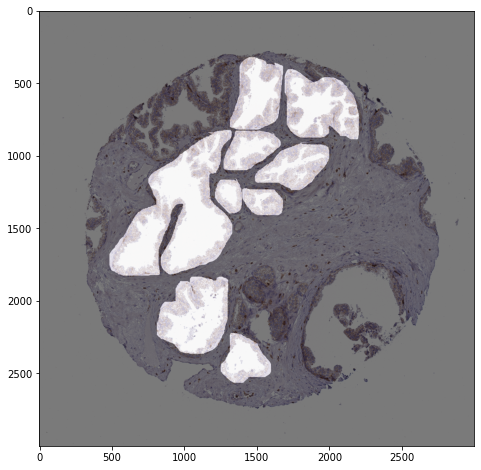

In [4]:
# https://www.kaggle.com/paulorzp/rle-functions-run-length-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T



path_img_test = df_final['image_path'].iloc[0]  
rle_mask_test = df_final['rle'].iloc[0]  
print(path_img_test)
# read img
img_test = tiff.imread(path_img_test)
# read mask
mask_test = rle2mask(rle_mask_test, (img_test.shape[1], img_test.shape[0]))

fig = plt.figure(figsize=(8, 8))
plt.imshow(img_test)
plt.imshow(mask_test, alpha=0.5, cmap='gray')
plt.show()

**RGB MASK**

In [5]:
# Tao mask theo class [prostate, spleen, lung, kidney, largeintestine] -> [red, green, blue, yellow, purple]
def mask1_mask3(mask1, organ):
    mask_background = np.zeros((mask1.shape[0],mask1.shape[1]), dtype=np.uint8)
    if organ == 'prostate':  #red
        mask3 = np.stack((mask1,mask_background,mask_background), axis=-1)
    elif organ == 'spleen': #green
        mask3 = np.stack((mask_background,mask1,mask_background), axis=-1)
    elif organ == 'lung': #blue
        mask3 = np.stack((mask_background,mask_background,mask1), axis=-1)
    elif organ == 'kidney': #red + green = yl
        mask3 = np.stack((mask1,mask1,mask_background), axis=-1)
    elif organ == 'largeintestine': #red + blue = purper
        mask3 = np.stack((mask1,mask_background,mask1), axis=-1)
        
    return mask3

# **Crop bounding**

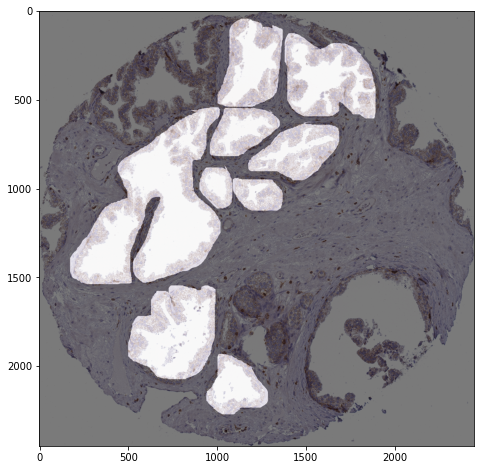

In [6]:
# https://stackoverflow.com/questions/67744433/how-to-extract-only-brain-part-in-center-in-mri-image

#Crop img,mask3
def crop(img, mask3):
    # ->Gray
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_c = 255 - grayscale_img
    # Gaussian blur
    img_gaussian = cv2.GaussianBlur(img_c,(5,5),1)
    # Otsu
    thres, thres_img = cv2.threshold(img_gaussian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh = cv2.morphologyEx(thres_img, cv2.MORPH_CLOSE, kernel)
    # get external contour (big contour)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)
    # get bounds of contour
    x,y,w,h = cv2.boundingRect(big_contour)
    # crop image and mask
    img_crop = img[y:y+h, x:x+w]
    mask_crop = mask3[y:y+h, x:x+w]
    
    #Resize -> hinh vuong
    if img_crop.shape[0] > img_crop.shape[1]:
        size = img_crop.shape[1]
    else: size = img_crop.shape[0]    
    img_res = cv2.resize(img_crop, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
    msk_res = cv2.resize(mask_crop, dsize=(size, size), interpolation=cv2.INTER_CUBIC)
    
    return img_res, msk_res


# Crop vien` thua`
img_crop_test, mask_crop_test = crop(img_test, mask_test)

fig = plt.figure(figsize=(8, 8))
plt.imshow(img_crop_test)
plt.imshow(mask_crop_test, alpha=0.5, cmap='gray')
plt.show()



**Circle Crop**

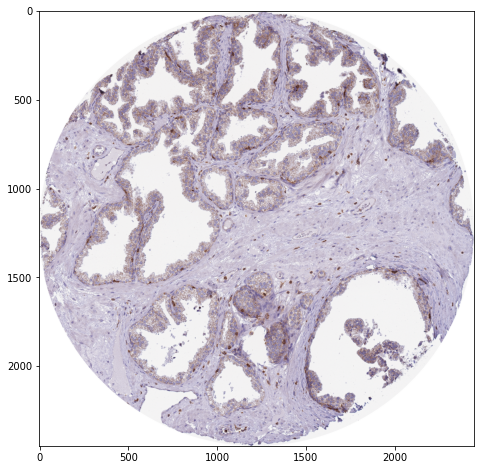

In [7]:
def crop_circle(image):
    hh, ww = image.shape[:2]
    hh2 = hh // 2
    ww2 = ww // 2
    # define circles
    radius = hh2
    yc = hh2
    xc = ww2
    # draw filled circle in white on black background as mask
    mask = np.zeros_like(image)
    mask = cv2.circle(mask, (xc,yc), radius, (255,255,255), -1)
    # apply mask to image
    result = cv2.bitwise_and(image, mask)
    result[result == 0] = 255
    
    return result

# Crop vien` hinh tron
img_c_test = crop_circle(img_crop_test)

fig = plt.figure(figsize=(8, 8))
plt.imshow(img_c_test)
# plt.imshow(mask_crop_test, alpha=0.5, cmap='gray')
plt.show()



# **Tiling images**

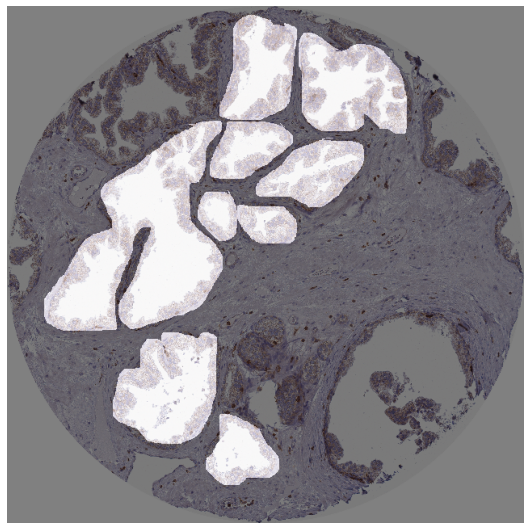

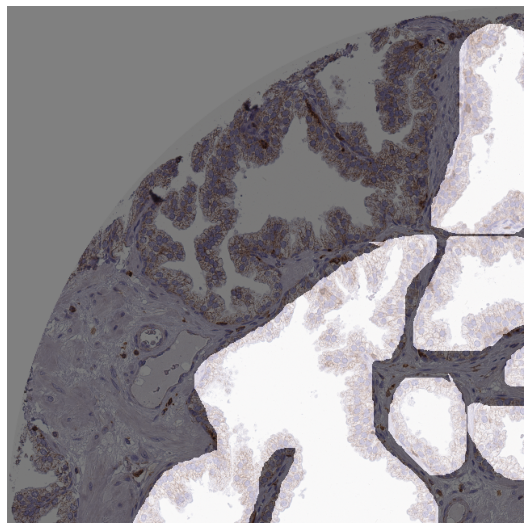

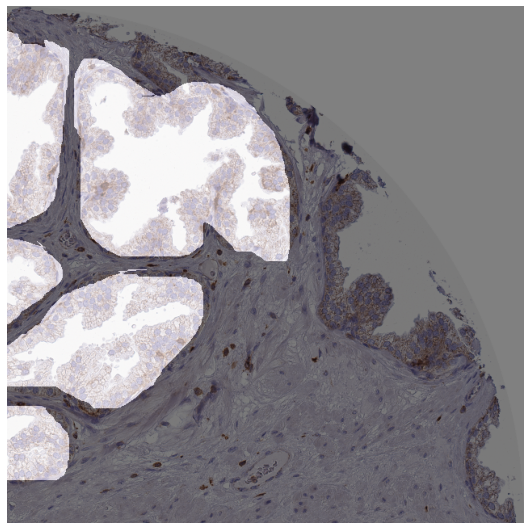

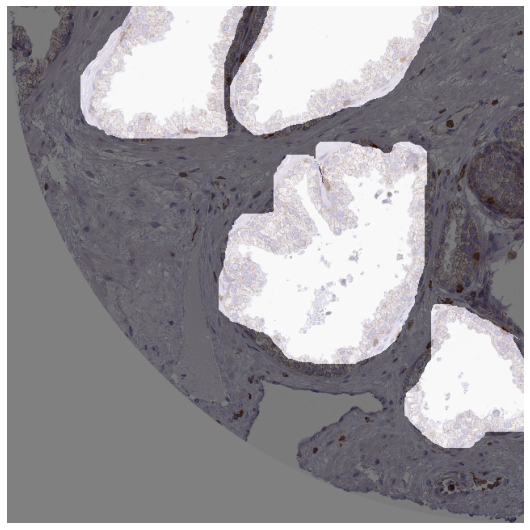

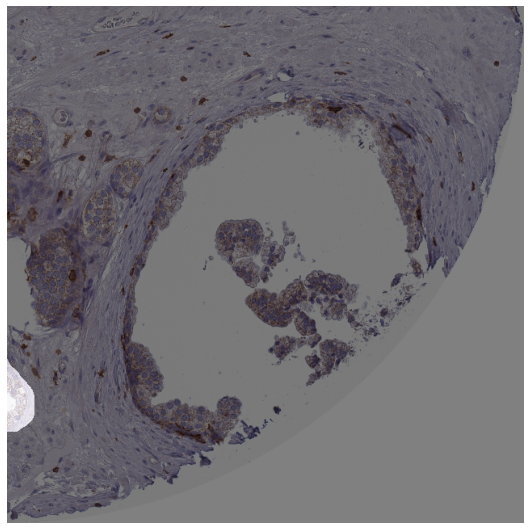

In [8]:
# Cat thanh nhieu anh nho? 1x1, 2x2, 3x3 (tiling images) with shape_image (256x256)
def tiling(image, mask, shape_image, size):
    
    #Resize (256xsize) size = 1,2,3
    wh_size = shape_image*size
    img_res = cv2.resize(image, dsize=(wh_size, wh_size), interpolation=cv2.INTER_CUBIC)
    msk_res = cv2.resize(mask, dsize=(wh_size, wh_size), interpolation=cv2.INTER_CUBIC)
    
    list_image_final = []
    list_mask_final = []
    # Size = 1
    if size == 1:
        list_image_final += [img_res]
        list_mask_final += [msk_res]
    
    # Size = 2,3,4,...
    elif size > 1:
        for w in range(0,size):
            for h in range(0,size):
                img_crop = img_res[shape_image*w:shape_image*(w+1), shape_image*h:shape_image*(h+1)]
                mask_crop = msk_res[shape_image*w:shape_image*(w+1), shape_image*h:shape_image*(h+1)]
                list_image_final += [img_crop]
                list_mask_final += [mask_crop]
    else : return 0
    
    return list_image_final, list_mask_final



# Resize + Cat thanh 1x1, 2x2, 3x3 
list_image_test = []
list_mask_test = []
for size in range(1,3):
    list_images, list_masks = tiling(img_c_test, mask_crop_test, shape_crop, size)
    list_image_test += list_images
    list_mask_test += list_masks
    
#Visualize
def visualize(img, mask):
    plt.figure(figsize=(9.5,9.5))
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5, cmap='gray')    
    plt.axis("off")

for i in range(len(list_image_test)):
    visualize(list_image_test[i], list_mask_test[i])

# **Save**

In [9]:
# save df_final
df_final.to_csv("/kaggle/working/df_train.csv", encoding='utf-8', index=False)

In [10]:

# Crop and Save
imgpath = r'/kaggle/working/Hubmap2022_256x256/image' 
if not os.path.exists(imgpath):
    os.makedirs(imgpath)

maskpath = r'/kaggle/working/Hubmap2022_256x256/mask' 
if not os.path.exists(maskpath):
    os.makedirs(maskpath)
    
values = range(len(df.index))
with tqdm(total=len(values), file=sys.stdout) as pbar:        
    for index, row in df_final.iterrows():
        id_img = str(row['id'])
        path_img = row['image_path']  
        rle = row['rle']

        # read img
        img_array = tiff.imread(path_img)
        # read mask
        mask_array = rle2mask(rle, (img_array.shape[1], img_array.shape[0]))

        # Crop vien` thua`
        img_crop, mask_crop = crop(img_array, mask_array)
    
        # Crop vien` hinh tron
        img_c = crop_circle(img_crop)

        # Resize + Cat thanh 1x1, 2x2, 3x3 
        list_image_finals = []
        list_mask_finals = []
        for size in range(1,4):
            list_images, list_masks = tiling(img_c, mask_crop, shape_crop, size)
            list_image_finals += list_images
            list_mask_finals += list_masks
        
        
        # save img/mask
        img_id_path = imgpath + '/' + id_img
        if not os.path.exists(img_id_path):
            os.makedirs(img_id_path)
            
        mask_id_path = maskpath + '/' + id_img
        if not os.path.exists(mask_id_path):
            os.makedirs(mask_id_path)
            
        for i in range(len(list_image_finals)):
            im = Image.fromarray(list_image_finals[i])
            im.save(img_id_path+"/"+str(i)+'_'+id_img+".png")

            mk = Image.fromarray(list_mask_finals[i])
            mk.save(mask_id_path+"/"+str(i)+'_'+id_img+".png")
        
        pbar.set_description('processed: %d' % (1 + index))
        pbar.update(1)    

processed: 351: 100%|██████████| 351/351 [12:26<00:00,  2.13s/it]


In [ ]:
!zip -r file.zip '/kaggle/working'

In [12]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/file.zip')

# from IPython.display import FileLink, FileLinks
# FileLinks('') #lists all downloadable files on server

/kaggle/working/file.zip